In [1]:
import mdtraj as md
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide(verbose=False)
fs_peptide.cache()

/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version.

In [2]:
# Work in a temporary directory
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
from msmbuilder.dataset import dataset
trajectories = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(trajectories)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in trajectories)))

/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length {500.0} ns


In [4]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = trajectories.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(trajectories[0].xyz.shape)
print(diheds[0].shape)

(1000, 264, 3)
(1000, 84)


In [5]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

(1000, 84)
(1000, 84)


In [6]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000, 84)
(1000, 4)


/Users/callumdickson/anaconda2/envs/msmbuilder/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


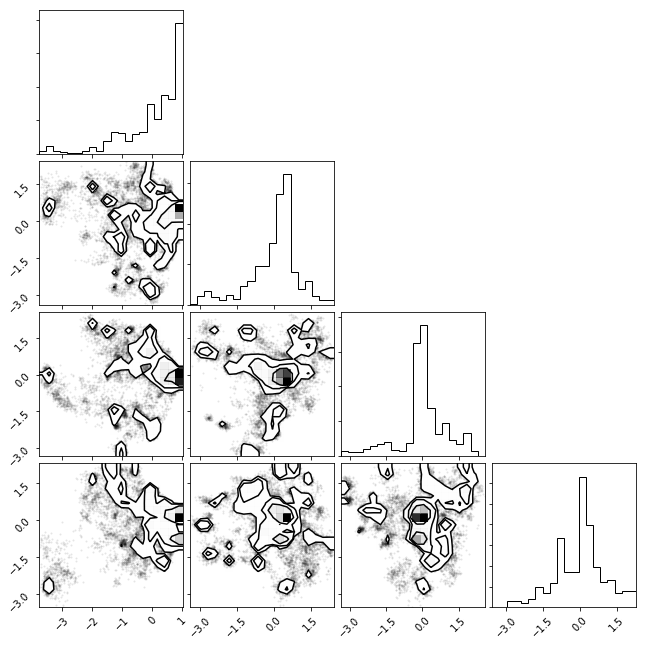

In [7]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [8]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000, 4)
(1000,)


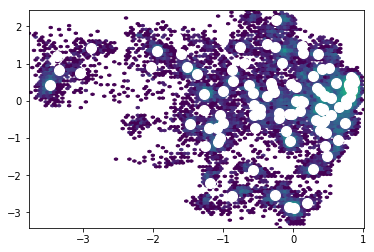

In [9]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [10]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

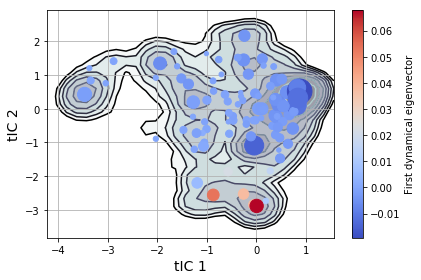

In [11]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)

msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

In [12]:
# transform on clustered_trajs to map back to msm assignmets - why
msm_assignments=msm.transform(clustered_trajs)

In [26]:
pairs = msm.draw_samples(msm_assignments, n_samples=5)


In [27]:
from msmbuilder.utils import map_drawn_samples

samples = map_drawn_samples(pairs, trajectories)

In [28]:
# Save the randomly sampled MSM states
coord_new = []

for state in range(0,len(samples)):
    for traj_id in samples[state]:
        coord_new.append(traj_id.xyz)
    
adaptive = md.Trajectory(np.concatenate(coord_new, axis=0), trajectories[0].topology)
adaptive.superpose(adaptive[0])
adaptive.save('adaptive.nc')

In [29]:
from msmbuilder.tpt import net_fluxes, paths
sources, sinks = [msm.populations_.argmin()], [msm.populations_.argmax()]
net_flux = net_fluxes(sources, sinks, msm)
paths, _ = paths(sources, sinks, net_flux, num_paths=0)

In [30]:
# Save the folding pathway
coord_new = []

for state in paths[0]:
    for traj_id in samples[state]:
        coord_new.append(traj_id.xyz)
pathway = md.Trajectory(np.concatenate(coord_new, axis=0), trajectories[0].topology)
pathway.superpose(pathway[0])
pathway.save('pathway.nc')

In [31]:
msm.timescales_


array([ 1828.39712674,  1249.05156066,   572.64450379,   311.83576047,
         304.83499194,   298.62208741,   229.75694066,   204.46270416,
         139.46187681,   132.14353997,   118.04011919,   110.4724879 ,
         105.30093279,    79.05111008,    69.94166198,    66.06612995,
          61.18444057,    53.25150699,    48.54605458,    46.21971236])

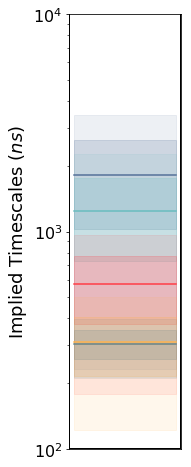

In [32]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

In [37]:
from msmbuilder.lumping import PCCAPlus

n_macrostates=4
pcca = PCCAPlus.from_msm(msm, n_macrostates)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.988809
         Iterations: 8
         Function evaluations: 87


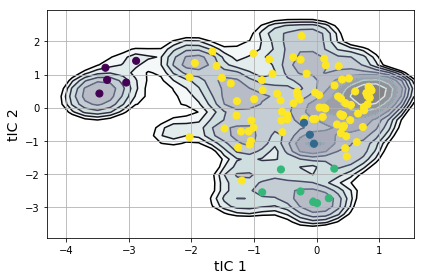

In [38]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()

In [39]:
samples=pcca.draw_samples(macro_trajs,n_samples=50)

In [43]:
# save the randomly sampled macrostates to different traj files
for macrostate in range(0,n_macrostates):
    coord_new = []

    for traj_id, frame in samples[macrostate]:
        coord_new.append(trajectories[traj_id][frame].xyz)
    
    macro = md.Trajectory(np.concatenate(coord_new, axis=0), trajectories[0].topology)
    macro.superpose(macro[0])
    macro.save('macrostate_%d.nc' % (macrostate))